# CSE 415 Deep Learning Assignment (A6)
Please go through the entire assignment, and read all lines of code, including the comments. However, only changes to areas of the code marked "**TO DO**" will be graded.

# Part 0: Pytorch Setup Code
Write your name where designated. Format: First name followed by last name with a space in between, and initials capitalized. For example:

name = 'Bindita Chaudhuri'

In [ ]:
# This shows how to connect your google drive account with a colab instance.

# Load the Drive helper and mount; this will prompt for authorization 
# (Login to google account; allow access, copy the code and paste it below and then press enter)
from google.colab import drive
drive.mount('/gdrive')

# create a folder named CSE415 in your Drive
import os 
BASE_PATH = '/gdrive/My Drive/CSE415/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
    
# now let's test that Google Drive is up and running. 
!ls "/gdrive/My Drive/CSE415"

# The following line will create a text file "foo.txt" in the created folder and then remove it
!echo "Hello Google Drive" > "/gdrive/My Drive/CSE415/foo.txt"
!cat "/gdrive/My Drive/CSE415/foo.txt"
!rm "/gdrive/My Drive/CSE415/foo.txt"

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.1
# CUDA enabled: True

import torch.nn as nn
import numpy as np
import glob, re, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import h5py, tqdm
import sys
sys.path.append(BASE_PATH)

# TO DO
# write your name here in the format mentioned above
name = 'Jerry Hong'


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
cifar10  language
Hello Google Drive
Version 1.4.0
CUDA enabled: True


In [ ]:
# Some useful save, restoring and conversion functions are provided below. No need to change them.

!pip3 install matplotlib-label-lines
from labellines import labelLines

class pt_util(object):
    # This does more than the simple Pytorch restore. It checks that the names 
    # of variables match, and if they don't doesn't throw a fit. It is similar 
    # to how Caffe acts. This is especially useful if you decide to change your
    # network architecture but don't want to retrain from scratch.
    @staticmethod
    def restore(net, save_file):
        """ Args:
        net(torch.nn.Module): The net to restore
        save_file(str): The file path
        """
        net_state_dict = net.state_dict()
        restore_state_dict = torch.load(save_file)

        restored_var_names = set()

        print('Restoring:')
        for var_name in restore_state_dict.keys():
            if var_name in net_state_dict:
                var_size = net_state_dict[var_name].size()
                restore_size = restore_state_dict[var_name].size()
                if var_size != restore_size:
                    print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
                else:
                    if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                        # backwards compatibility for serialized parameters
                        net_state_dict[var_name] = restore_state_dict[var_name].data
                    try:
                        net_state_dict[var_name].copy_(restore_state_dict[var_name])
                        print(str(var_name)+' -> \t'+str(var_size)+' = '+str(int(np.prod(var_size)*4 / 10**6)) + 'MB')
                        restored_var_names.add(var_name)
                    except:
                        print('While copying the parameter named {}, whose dimensions in the model are'
                              ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                                  var_name, var_size, restore_size))
                        raise

        ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
        unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
        print('')
        if len(ignored_var_names) == 0:
            print('Restored all variables')
        else:
            print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
        if len(unset_var_names) == 0:
            print('No new variables')
        else:
            print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

        print('Restored %s' % save_file)
        
    # Restores the last saved network in a folder using file write time.
    @staticmethod
    def restore_latest(net, folder):
        """
        Args:
          net(torch.nn.module): The net to restore
          folder(str): The folder path
        Returns:
          int: Attempts to parse the epoch from the state and returns it if possible. Otherwise returns 0.
        """
        checkpoints = sorted(glob.glob(folder + '/*.pt'), key=os.path.getmtime)
        start_it = 0
        if len(checkpoints) > 0:
            pt_util.restore(net, checkpoints[-1])
            start_it = int(re.findall(r'\d+', checkpoints[-1])[-1])
        return start_it

    # Saves the network and optionally deletes old save files. 
    # If num_to_keep is 0, it won't remove any.
    @staticmethod
    def save(net, file_name, num_to_keep=1):
        """
        Args:
        net(torch.nn.module): The network to save
        file_name(str): the path to save the file.
        num_to_keep(int): Specifies how many previous saved states to keep once this one has been saved.
            Defaults to 1. Specifying < 0 will not remove any previous saves.
        """
        folder = os.path.dirname(file_name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(net.state_dict(), file_name)
        extension = os.path.splitext(file_name)[1]
        checkpoints = sorted(glob.glob(folder + '/*' + extension), key=os.path.getmtime)
        print('Saved %s\n' % file_name)
        if num_to_keep > 0:
            for ff in checkpoints[:-num_to_keep]:
                os.remove(ff)
                

    @staticmethod
    def to_numpy(array):
        if isinstance(array, torch.Tensor):
            return array.detach().cpu().numpy()
        elif isinstance(array, dict):
            return {key: pt_util.to_numpy(val) for key, val in array.items()}
        else:
            return np.asarray(array)

    @staticmethod
    def from_numpy(np_array):
        if isinstance(np_array, list):
            try:
                np_array = np.stack(np_array, 0)
            except ValueError:
                np_array = np.stack([from_numpy(val) for val in np_array], 0)
        elif isinstance(np_array, dict):
            return {key: from_numpy(val) for key, val in np_array.items()}
        np_array = np.asarray(np_array)
        if np_array.dtype == np.uint32:
            print("numpy -> torch dtype uint32 not supported, using int32")
            np_array = np_array.astype(np.int32)
        elif np_array.dtype == np.dtype("O"):
            print("numpy -> torch dtype Object not supported, returning numpy array")
            return np_array
        elif np_array.dtype.type == np.str_:
            print("numpy -> torch dtype numpy.str_ not supported, returning numpy array")
            return np_array
        return torch.from_numpy(np_array)

    @staticmethod
    def write_log(filename, data):
        """Pickles and writes data to a file
        Args:
            filename(str): File name
            data(pickleable object): Data to save
        """
        if not os.path.exists(os.path.dirname(filename)):
          os.makedirs(os.path.dirname(filename))
        pickle.dump(data, open(filename, 'wb')) 

    def read_log(filename, default_value=None):
        """Reads pickled data or returns the default value if none found
        Args:
            filename(str): File name
            default_value(anything): Value to return if no file is found
        Returns:
            unpickled file
        """
        if os.path.exists(filename):
            return pickle.load(open(filename, 'rb'))
        return default_value
    
    # Create plots
    @staticmethod
    def plot(x_values, y_values, title, xlabel, ylabel, plotlabel):
        """Plots a line graph
        Args:
            x_values(list or np.array): x values for the line
            y_values(list or np.array): y values for the line
            title(str): Title for the plot
            xlabel(str): Label for the x axis
            ylabel(str): label for the y axis
        """
        plt.figure(figsize=(20, 10))
        plt.plot(x_values, y_values, label=plotlabel, color='b')
        labelLines(plt.gca().get_lines(), color='b',fontsize=13)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def to_scaled_uint8(array):
        """Returns a normalized uint8 scaled to 0-255. This is useful for showing images especially of floats.
        Args:
            array(np.array): The array to normalize
        Returns:
            np.array normalized and of type uint8
        """
        array = np.array(array, dtype=np.float32)
        array -= np.min(array)
        array *= (255. / np.max(array))
        array = array.astype(np.uint8)
        return array

# Part 1: Classification Network for CIFAR-10

# 1.1 Loading and transforming data

CIFAR-10 data consists of 60000 32x32 images, belonging to 10 classes. More details can be found here:
https://www.cs.toronto.edu/~kriz/cifar.html

Note: Each image is a matrix of shape width x height (W x H) with 3 channels (C).

The code for loading the dataset and transforming the data accordingly is provided. 
The transform *ToTensor* converts the output from the dataset to be a tensor in CxHxW format.
One type of data augmentation - data normalization, is shown in the transforms. You have to add at least 2 of the following data augmentations in 'transform_train' (try to understand which ones you need, and what parameters you should choose for them):

- RandomHorizontalFlip
- RandomCrop
- ColorJitter
- RandomRotation


# 1.2 Defining network

You need to define a convolutional neural network (CNN) to classify the data into its classes. Sample code for classification of MNIST (handwritten digits dataset) is given here: https://github.com/pytorch/examples/blob/master/mnist/main.py

You will define the network layers in the `__init__` function, and the forward call will pass the data through those layers. The network should be as follows:

- One 3x3 convolution layer with 32 filters.
- One 2x2 maxpooling layer
- One 3x3 convolution layer with 64 filters. 
- One 3x3 convolution layer with 64 filters. 
- One 2x2 maxpooling layer
- One 3x3 convolution layer with 128 filters. 
- One 3x3 convolution layer with 128 filters.
- One 2x2 maxpooling layer
- One fully connected layer with 512 outputs.
- Then the final classification layer with 10 outputs.

- Every convolution layer should be followed by ReLU nonlinearity followed by batch normalization. Use padding in every convolution layer to retain input image size.
        


# Helpful functions
- https://pytorch.org/docs/stable/tensors.html
- https://pytorch.org/docs/stable/nn.html
- You can call `pt_util.to_numpy(x)` to get a numpy array from a torch tensor x.
- `pt_util.from_numpy(x)` makes a torch Tensor from the numpy array x.

# Common Oopsies
- __Q__ It only runs for one iteration and says it's done: __A__ We provided code that automatically loads the most recent file. If you don't want to start from that checkpoint, simply find it in your google drive and delete it.
- __Q__ I want to save more than just the last checkpoint: __A__ You can change the save function to save any number of previous checkpoints. You can also tell it to save all of them (not delete anything), by passing in 0.
- __Q__ Pytorch is saying things are the wrong shape: __A__ You can easily reshape things using the `view` function (https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view). It is like the Numpy `reshape` function.
- __Q__ Pytorch is saying things are on the wrong device: __A__ You can move data between devices with the `.to(device)` call. Generally, all arguments to a function will need to be on the same device.

In [ ]:
# Data augmentation

transform_train = transforms.Compose([
    # TO DO
    transforms.RandomHorizontalFlip(10),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the dataset

DATA_PATH = BASE_PATH + 'cifar10/'
data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)


# This is where you define your network architecture.
# You can use that as a guide, but make sure you understand what it all does.

class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.best_accuracy = -1
        # TO DO
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 128, 3, 1, 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(64)
        self.batch4 = nn.BatchNorm2d(128)
        self.batch5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 10)
        
        
    def forward(self, x):
        # TO DO 
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.batch1(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.batch3(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.batch4(x)
        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = self.batch5(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
      
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Files already downloaded and verified
Files already downloaded and verified


# 1.3 Training and testing the network

The train and test functions are given below. Fill in the TO DO with the given instructions. At the end, training and testing loss and accuracy plots will be displayed. Right click on the plots and save them as png files. Put these images on a single page (titled **CIFAR plots**) in your report, which you can create as a doc file but you will need to convert it into a pdf for submission. You also need to submit the 'cifar_050.pt' file from the 'checkpoints' folder inside your 'cifar10' folder.

In [ ]:
import time

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        # send the data and labels to GPU
        data, label = data.to(device), label.to(device)
        # initialize the optimizer
        optimizer.zero_grad()
        # TO DO (call the 'model' with 'data' as input)
        output = model(data)
        # TO DO (call the model.loss function with 'output' and 'label' as inputs) 
        loss = model.loss(output, label)
        
        # backpropagate the loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Log the training progress
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            # send data and label to GPU
            data, label = data.to(device), label.to(device)
            # TO DO (call the model with 'data' as input)
            output = model(data)
            # TO DO (call model.loss function with 'output and 'label' as inputs and reduction='sum')
            test_loss_on = model.loss(output, label, reduction='sum')
            
            test_loss += test_loss_on.item()
            
            # Take the class with maximum probability as the output class.
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            
            # Log the test progress
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy


In [ ]:
# Now the actual training and testing code

import multiprocessing
import traceback

# Play around with these constants, you may find a better setting.
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'

# handle GPU connection and multiprocessing
use_cuda = USE_CUDA and torch.cuda.is_available()
torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# iterator over the data
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)

# Initialize network and send it to GPU
model = CifarNet().to(device)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# This will train from scratch
start_epoch = 0 
train_losses, test_losses, test_accuracies = [], [], []

# To resume training from last saved model, uncomment the following 2 lines
# start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
# train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

# Get the initial test losses and accuracies
test_loss, test_accuracy = test(model, device, test_loader)
test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        # train the model for 1 epoch
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        train_losses.append((epoch, train_loss))
        # test the model after 1 epoch
        test_loss, test_accuracy = test(model, device, test_loader)
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        # Log the losses and accuracy
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        # save the current model in the checkpoints folder
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/cifar_%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(DATA_PATH + 'checkpoints/cifar_%03d.pt' % epoch, 0)
    # Plot the loss and accuracy values over epochs
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error', name)
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error', name)
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error', name)


# 1.4 Attempt to use your own test data

Download 5 images for each of the 4 classes given below. Choose the images randomly from Google, but make sure they look somewhat similar to the training data of CIFAR-10 in terms of content. For example, full body image of a dog with minimal background is recommended. Edit the text below to write down the links of the images (**NOTE**: The TAs will be evaluating YOUR network weights with YOUR chosen images, so do not collaborate with others regarding image choices.)

Plane:

- https://i.insider.com/5d8547db2e22af5bc9096d0d?width=1100&format=jpeg&auto=webp
- https://cdn.cnn.com/cnnnext/dam/assets/190906095526-american-airlines-mechanic-faces-sabotage-charge-marsh-nr-vpx-00000225-exlarge-169.jpg
- https://s.abcnews.com/images/US/airbus-gty-er-190417_hpMain_16x9_992.jpg
- https://www.traveller.com.au/content/dam/images/h/1/9/m/g/3/image.related.articleLeadwide.620x349.h1aa81.png/1548048327915.jpg
- https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/DeltaFlightIstockBoeing767.jpg?ve=1&tl=1

Car:

- https://www.extremetech.com/wp-content/uploads/2019/12/SONATA-hero-option1-764A5360-edit-640x354.jpg
- https://c.ndtvimg.com/2019-08/k8519lf8_bugatti-centodieci-unveiled-at-pebble-beach-car-show_625x300_17_August_19.jpg
- https://specials-images.forbesimg.com/imageserve/5d35eacaf1176b0008974b54/960x0.jpg?cropX1=790&cropX2=5350&cropY1=784&cropY2=3349
- https://static.carsdn.co/cldstatic/wp-content/uploads/HP2020BMWZ4-e1579802967802.jpg
- https://media.wired.com/photos/5d09594a62bcb0c9752779d9/master/pass/Transpo_G70_TA-518126.jpg

Dog:

- https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2019/02/dog-451643.jpg?h=bf654dbc&itok=MQGvBmuo
- https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/smartest-dog-breeds-1553287693.jpg?crop=0.671xw:1.00xh;0.167xw,0&resize=640:*
- https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg
- https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?w=1155&h=1541
- https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/alaskan-malamute-card-large.jpg?bust=1535569394


Horse:

- https://www.thesprucepets.com/thmb/KYaXBSM013GnZ2jEZJnX4a9oIsU=/3865x2174/smart/filters:no_upscale()/horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg
- https://ichef.bbci.co.uk/news/1024/cpsprodpb/1245A/production/_103224847_horsea.png
- https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/horse.jpg?ve=1&tl=1
- https://blogs.gartner.com/debbie_wilson/files/2019/10/horse.jpg
- https://thehorse.com/wp-content/uploads/2017/01/iStock-510488648.jpg

Now upload these images in the 'cifar10' folder in your drive. Then write a function show_images() to plot the images in a 4 x 5 grid using matplotlib. Functions to use among others:

- plt.subplot() or fig.add_subplot()
- plt.imshow() or ax.imshow()
- plt.axis('off') or ax.set_axis_off()
- plt.show()
- Image.open() from PIL (convert to numpy array before use in imshow) 

Once done, right click on the grid and click 'Save Image As'. Put the image in your report on a page (titled **External Images**).

# EXTRA CREDIT (20 points)
Use these images as the test set and check the accuracy of your trained model on this custom test set. A useful article: https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f


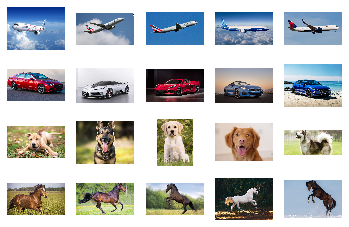

In [ ]:
# TO DO : image visualization; you can modify anything here
from PIL import Image
def show_images():
    image_list = []
    image_list.append('/gdrive/My Drive/CSE415/cifar10/plane1.jpeg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/plane2.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/plane3.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/plane4.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/plane5.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/car1.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/car2.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/car3.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/car4.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/car5.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/dog1.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/dog2.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/dog3.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/dog4.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/dog5.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/horse1.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/horse2.png')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/horse3.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/horse4.jpg')
    image_list.append('/gdrive/My Drive/CSE415/cifar10/horse5.jpg')

    fig, axs = plt.subplots(4, 5)
    for i in range(4):
      for j in range(5):
        image = Image.open(image_list[i * 5 + j])
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
    
    plt.show()

show_images()
# EXTRA CREDIT CODE HERE (IF ANY)

# Part 2: Language generation using character-level RNNs

# 2.1 Processing the data

We'll be using the complete text of Harry Potter as our corpus. Place the harry_potter.txt file provided in the 'language' folder created in your drive.

1) Create a dictionary voc2ind to define the vocabulary. voc2ind contents will be like `{' ': 0, 'A': 1, 'B': 2, 'C': 3, ... '0': 35, '1': 36, ..., '$': 78, '#': 79, '(': 80, ...}`. The keys include all the 26 alphabets, both upper case and lower case separately, digits 0-9 and special characters that may appear in a general text. The values corresponding to the keys can be in any order. You may have to handle single and double quotes carefully in the keys since they are generally used as string delimiters. ind2voc is the inverse of voc2ind.

2) Now using the vocabulary above, convert text into a list of tokens. For example, if the text is **`"ABA CDBE"`**, the token version will be a list with contents `[1, 2, 1, 0, 3, 4, 2, 5]`. Create this list where instructed below.

3) train_text and test_text should contain the first 80% and the last 20% of the 'token' list. This should be simple to write.


In [ ]:
DATA_PATH = BASE_PATH + 'language/'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TO DO (create the voc2ind dictionary)
    voc2ind = {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 
               'k': 11, 'l': 12, 'm':13, 'n':14, 'o': 15, 'p': 16, 'q':17, 'r': 18, 's': 19, 't': 20, 
               'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 
               'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 
               'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 
               'Y': 51, 'Z': 52, '0': 53, '1': 54, '2': 55, '3': 56, '4': 57, '5': 58, '6': 59, '7': 60, 
               '8': 61, '9': 62, ',': 63, '.': 64, '?': 65, '!': 66, '@': 67, '#': 68, '$': 69, '%': 70, 
               '^': 71, '*': 72, '(': 73, ')': 74, '-': 75, '_': 76, '=': 77, '+': 78, ':': 79, ';': 80, 
               '<': 81, '>': 82, '/': 83, '\'': 84, '\"': 85, '~': 86, '`': 87, '\\': 88, '[': 89, ']': 90,
               '|': 91, '&': 92, '{': 93, '}': 94}
    
    # transform the data into an integer representation of the tokens.
    token = []
    for char in data:
        # replaces all weird spacing like tab, next line etc. with space
        if re.match('\s+', char): char = ' '
        # TO DO (create the list of tokens; basically replace None with the correct expression)
        token.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    # TO DO 
    train_text = token[0 : int(len(token) * 0.8)]
    test_text = token[int(len(token) * 0.8) : int(len(token))]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    print('Data prepared!')
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Data prepared!


Now we have to load the data. There's nothing to do here on your part, but this is an explanation of what is going on. First imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, we should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Note:
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- The last label in one batch is the first data in the next batch.

In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # make dataset length a multiple of batch size
        # removing the last bit to make the data the proper shape mostly gives better results than padding with 0s.
        new_dataset_length = (len(dataset['tokens'])//self.batch_size) * self.batch_size        
        self.tokens = dataset['tokens'][:new_dataset_length]

        self.chunk_size = int(new_dataset_length / self.batch_size)

    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
        return self.batch_size * int(np.ceil((self.chunk_size-1)/self.sequence_length))
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence
        # Return a single entry for the batch using the idx to decide which chunk you are in and how far down in the chunk you are.
        chunk_idx = idx % self.batch_size
        pos_idx = idx // self.batch_size

        start_idx = self.chunk_size * chunk_idx + self.sequence_length * pos_idx
        end_idx = self.chunk_size * chunk_idx + min(self.sequence_length * pos_idx + self.sequence_length + 1, self.chunk_size)

        data = self.tokens[start_idx : end_idx]
        # The data and labels should be torch long tensors.
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

# 2.2 Defining the network

The network, a generic RNN is defined below for you. Just replace the GRU layer with an LSTM layer. You can look up LSTM definition in Pytorch online. Then, implement the forward pass as instructed.

In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # TO DO (replace the following line with LSTM layer)
        self.LSTM = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TO DO 
        # pass x though the encoder first, then through LSTM, then through the decoder.
        # return items from LSTM layer should be both the output and the hidden state.
        x = self.encoder(x)
        x, hidden_state = self.LSTM(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# 2.3 Character generation and training

You don't have to write any code in this part. Just understand how the steps work. The training and testing functions and the main function are quite similar to the ones in Part 1. Here is an interesting article about sampling strategies (we have used max sampling strategy here for convenience):
https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

Feel free to modify various portions of the code to understand better, and refer to online resources. Natural Language Processing details are beyond the scope of this course.

At the end, save the 3 plots (train loss, test loss and test accuracy) as before and put them in your report on a single page (titled **NLP plots**). In addition, write down (in your report) the generated sentence that will be displayed at the end. You will also need to submit 'language_020.pt' file from 'checkpoints' folder in your 'language' folder.


In [ ]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10
import tqdm

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
    

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    ind = torch.argmax(output)
    for ii in range(sequence_length):
        output, hidden = model.inference(ind, hidden, TEMPERATURE)
        ind = torch.argmax(output)
        outputs.append(ind)
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)
    

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        # send data and label to GPU
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
               
        optimizer.zero_grad()
        # run the model and get the prediction
        output, hidden = model(data)
        pred = output.max(-1)[1]
        
        # compute and backpropagate the loss
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            # send data and label to GPU
            data, label = data.to(device), label.to(device)
            
            # test the model
            output, hidden = model(data, hidden)
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            
            # compute test loss
            test_loss += model.loss(output, label, reduction='mean').item()
            
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	3zoo^Rs5^|eVyV^3[yVy^^slelf[qems%>\0Ve||e0*!^^^ee^e||&zeS^m^^'*T^33^VV0V|:oSm:m***uVVeze6l^3[^^e00em


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	*i^^e^l^ee^^mTTs^.3^^^^^VVee*ee^^u*R[V5||m"S^q>>CfsGS^mT^3[^^e^fslellTT^^^e^>o|e>CdVYe0*R^s<qEee^^3[


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	eV^bOszS^^mTTVVeVV^eVyV^^e0yl3:zS^s>O^^eu^|m5yVS^^m*0szS^qeysz^^&l<s^!7^]u*R['|3R|5^ezS^':^Vo7UOq>>I


Input	 . .

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 9.3763, Accuracy: 14497/1254400 (1%)



  1%|          | 2/196 [00:00<00:38,  5.05it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 9.371389


  6%|▌         | 12/196 [00:01<00:20,  9.08it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 4.625881


 11%|█         | 22/196 [00:02<00:19,  9.06it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 2.824799


 16%|█▋        | 32/196 [00:03<00:17,  9.14it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 2.343783


 21%|██▏       | 42/196 [00:04<00:17,  9.04it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.113458


 27%|██▋       | 52/196 [00:05<00:15,  9.14it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.043002


 32%|███▏      | 62/196 [00:06<00:15,  8.77it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 1.988430


 37%|███▋      | 72/196 [00:08<00:13,  8.87it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 1.957008


 42%|████▏     | 82/196 [00:09<00:12,  9.10it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 1.903338


 47%|████▋     | 92/196 [00:10<00:11,  9.25it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 1.857528


 52%|█████▏    | 102/196 [00:11<00:10,  8.92it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 1.848537


 57%|█████▋    | 112/196 [00:12<00:09,  8.93it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 1.834373


 62%|██████▏   | 122/196 [00:13<00:08,  8.94it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 1.795443


 67%|██████▋   | 132/196 [00:14<00:07,  8.98it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 1.760342


 72%|███████▏  | 142/196 [00:15<00:06,  8.97it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 1.762783


 78%|███████▊  | 152/196 [00:16<00:04,  9.04it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 1.740798


 83%|████████▎ | 162/196 [00:18<00:03,  8.92it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 1.745026


 88%|████████▊ | 172/196 [00:19<00:02,  8.85it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.706609


 93%|█████████▎| 182/196 [00:20<00:01,  9.01it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.716587


 98%|█████████▊| 192/196 [00:21<00:00,  9.04it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.690255


100%|██████████| 196/196 [00:21<00:00,  8.97it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney tas aott th tot tascr  au ause toldemort tad baacged tn whmt . "e woorg tis elf tner th the snre


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet ted bes hno  "  weal dh  tim  aocl ng teck art tn o the sascr tath h sheayse te sahateledoth t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes hall tott the soaund tn the  wokter tim and teean ah toney aam  ahiw y tnd thre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_000.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started 



  1%|          | 2/196 [00:00<00:33,  5.78it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.685813


  6%|▌         | 12/196 [00:01<00:21,  8.62it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.647438


 11%|█         | 22/196 [00:02<00:19,  8.81it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.669549


 16%|█▋        | 32/196 [00:03<00:18,  8.89it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.644989


 21%|██▏       | 42/196 [00:04<00:17,  8.87it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.628532


 27%|██▋       | 52/196 [00:05<00:16,  8.81it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.622245


 32%|███▏      | 62/196 [00:07<00:15,  8.91it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.618903


 37%|███▋      | 72/196 [00:08<00:14,  8.83it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.627404


 42%|████▏     | 82/196 [00:09<00:13,  8.74it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.600162


 47%|████▋     | 92/196 [00:10<00:11,  8.91it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.580621


 52%|█████▏    | 102/196 [00:11<00:10,  8.83it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.591423


 57%|█████▋    | 112/196 [00:12<00:09,  8.74it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.586138


 62%|██████▏   | 122/196 [00:13<00:08,  8.62it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.567888


 67%|██████▋   | 132/196 [00:14<00:07,  8.83it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.553159


 72%|███████▏  | 142/196 [00:16<00:06,  8.96it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.560722


 78%|███████▊  | 152/196 [00:17<00:04,  8.94it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.548553


 83%|████████▎ | 162/196 [00:18<00:03,  8.70it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.570317


 88%|████████▊ | 172/196 [00:19<00:02,  9.06it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.531454


 93%|█████████▎| 182/196 [00:20<00:01,  8.85it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.556340


 98%|█████████▊| 192/196 [00:21<00:00,  8.94it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.553409


100%|██████████| 196/196 [00:22<00:00,  8.87it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas aott th tet tascr  au ause teldemort ted buacted tt wtmt . .e wootg tem elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet hed bem hno  "t wesltded tem  aocling aeck ard tt o the cascr thth h lteacse he htaetbled th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tem haet hitt the criund tn the  wikted tim and te an ah tonei aem  atiwly and ttde l  "uck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.5593, Accuracy: 677563/1254400 (54%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_001.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I did not the could he had been the did not the could he had been the did not the could he had been the did not the could he had been the did not the could he had been the did not the could he had bee



  1%|          | 2/196 [00:00<00:31,  6.12it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.548498


  6%|▌         | 12/196 [00:01<00:21,  8.72it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.516473


 11%|█         | 22/196 [00:02<00:19,  8.92it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.545314


 16%|█▋        | 32/196 [00:03<00:18,  8.84it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.522187


 21%|██▏       | 42/196 [00:04<00:17,  8.98it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.508319


 27%|██▋       | 52/196 [00:05<00:16,  8.81it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.500438


 32%|███▏      | 62/196 [00:07<00:15,  8.86it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.525956


 37%|███▋      | 72/196 [00:08<00:13,  8.87it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.516113


 42%|████▏     | 82/196 [00:09<00:12,  8.97it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.488935


 47%|████▋     | 92/196 [00:10<00:11,  8.99it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.488794


 52%|█████▏    | 102/196 [00:11<00:10,  8.90it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.517021


 57%|█████▋    | 112/196 [00:12<00:09,  8.88it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.503272


 62%|██████▏   | 122/196 [00:13<00:08,  8.99it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.490116


 67%|██████▋   | 132/196 [00:14<00:07,  8.77it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.470080


 72%|███████▏  | 142/196 [00:16<00:06,  8.52it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.487464


 78%|███████▊  | 152/196 [00:17<00:04,  9.00it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.476797


 83%|████████▎ | 162/196 [00:18<00:03,  8.95it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.491689


 88%|████████▊ | 172/196 [00:19<00:02,  9.00it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.461813


 93%|█████████▎| 182/196 [00:20<00:01,  8.81it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.493196


 98%|█████████▊| 192/196 [00:21<00:00,  9.07it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.491999


100%|██████████| 196/196 [00:22<00:00,  8.88it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas toat th tet tascr  tu ause toldemort wad buantid tn womt . .a woong oim elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bem fno  "t wealaled tim  aocling aack ard tn o the salcr thth h lheacs  he sahaibled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and ses faet aift the sround tn the  wikted tim and se an to toney tim  aoiwly and stre y  "uck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4892, Accuracy: 701864/1254400 (56%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_002.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was stairing the stairs was stairing the stairs was stairing the stairs was stairing the stairs was stairing the stairs was stairing the stairs was stairing the stairs was stairing the stairs wa



  1%|          | 2/196 [00:00<00:31,  6.17it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.479086


  6%|▌         | 12/196 [00:01<00:21,  8.65it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.448979


 11%|█         | 22/196 [00:02<00:20,  8.67it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.480578


 16%|█▋        | 32/196 [00:03<00:18,  8.92it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.460422


 21%|██▏       | 42/196 [00:04<00:17,  8.98it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.452574


 27%|██▋       | 52/196 [00:05<00:16,  8.89it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.446352


 32%|███▏      | 62/196 [00:07<00:15,  8.70it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.455649


 37%|███▋      | 72/196 [00:08<00:14,  8.84it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.458231


 42%|████▏     | 82/196 [00:09<00:13,  8.75it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.460987


 47%|████▋     | 92/196 [00:10<00:11,  8.88it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.434572


 52%|█████▏    | 102/196 [00:11<00:10,  8.73it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.446262


 57%|█████▋    | 112/196 [00:12<00:09,  8.90it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.450411


 62%|██████▏   | 122/196 [00:13<00:08,  8.78it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.436728


 67%|██████▋   | 132/196 [00:15<00:07,  8.73it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.418528


 72%|███████▏  | 142/196 [00:16<00:06,  8.61it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.436072


 78%|███████▊  | 152/196 [00:17<00:05,  8.56it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.431704


 83%|████████▎ | 162/196 [00:18<00:03,  8.57it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.449882


 88%|████████▊ | 172/196 [00:19<00:02,  8.80it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.428072


 93%|█████████▎| 182/196 [00:20<00:01,  8.78it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.450243


 98%|█████████▊| 192/196 [00:21<00:00,  8.67it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.453643


100%|██████████| 196/196 [00:22<00:00,  8.75it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th tet tascri tucause heldemort wad tuanted tn wemt . "e woong oem elf aner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what hed bes hnm  "t wealased tim  aocleng aeck ard tn o the dalcr aath anlheach  he waheweled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes haet aift the dround an the  wekted tim and teean to toneyitim  ahiwly and ttre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4519, Accuracy: 712925/1254400 (57%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_003.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, I don't the one of the one of the one of the one of the one of the could have to the one of the could have been the door wand the fire of the could have been the door wand the door wand the doo



  1%|          | 2/196 [00:00<00:31,  6.18it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.445940


  6%|▌         | 12/196 [00:01<00:20,  8.76it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.408586


 11%|█         | 22/196 [00:02<00:19,  8.75it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.438908


 16%|█▋        | 32/196 [00:03<00:18,  8.64it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.421141


 21%|██▏       | 42/196 [00:04<00:17,  8.85it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.409000


 27%|██▋       | 52/196 [00:05<00:16,  8.81it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.404960


 32%|███▏      | 62/196 [00:07<00:15,  8.78it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.417644


 37%|███▋      | 72/196 [00:08<00:14,  8.71it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.428081


 42%|████▏     | 82/196 [00:09<00:13,  8.63it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.436176


 47%|████▋     | 92/196 [00:10<00:11,  8.85it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.410242


 52%|█████▏    | 102/196 [00:11<00:10,  8.84it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.416730


 57%|█████▋    | 112/196 [00:12<00:09,  8.72it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.420062


 62%|██████▏   | 122/196 [00:13<00:08,  8.63it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.408130


 67%|██████▋   | 132/196 [00:15<00:07,  8.65it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.404964


 72%|███████▏  | 142/196 [00:16<00:06,  8.81it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.407282


 78%|███████▊  | 152/196 [00:17<00:05,  8.53it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.430684


 83%|████████▎ | 162/196 [00:18<00:03,  8.51it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.426234


 88%|████████▊ | 172/196 [00:19<00:02,  8.65it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.403573


 93%|█████████▎| 182/196 [00:20<00:01,  8.73it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.429787


 98%|█████████▊| 192/196 [00:21<00:00,  8.58it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.428099


100%|██████████| 196/196 [00:22<00:00,  8.75it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney tas toat th tet thscri aucause holdemort wad tuaceed tn womt . "e woung oem elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	hhhat hed tes hnm  "t weaease  tim  aocleng aack ard tn o the calcr aath anlhiach  he wahemeled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoft the cround an the  wokted tim and tefan to toley aim  ahiwly,and ttrp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4241, Accuracy: 723516/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_004.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you were the one of the one of the one of the one of the course of the count of the count of the count of the counter of the counter of the counter of the counter of the counter of 



  1%|          | 2/196 [00:00<00:32,  5.88it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.419884


  6%|▌         | 12/196 [00:01<00:21,  8.71it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.389593


 11%|█         | 22/196 [00:02<00:20,  8.52it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.419757


 16%|█▋        | 32/196 [00:03<00:19,  8.62it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.399120


 21%|██▏       | 42/196 [00:04<00:18,  8.42it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.396391


 27%|██▋       | 52/196 [00:06<00:16,  8.67it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.407671


 32%|███▏      | 62/196 [00:07<00:15,  8.46it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.442981


 37%|███▋      | 72/196 [00:08<00:14,  8.72it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.418251


 42%|████▏     | 82/196 [00:09<00:13,  8.54it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.387214


 47%|████▋     | 92/196 [00:10<00:11,  8.74it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.383053


 52%|█████▏    | 102/196 [00:11<00:11,  8.48it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.401050


 57%|█████▋    | 112/196 [00:13<00:09,  8.77it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.406093


 62%|██████▏   | 122/196 [00:14<00:08,  8.51it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.398174


 67%|██████▋   | 132/196 [00:15<00:07,  8.65it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.404257


 72%|███████▏  | 142/196 [00:16<00:06,  8.66it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.403095


 78%|███████▊  | 152/196 [00:17<00:05,  8.60it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.385004


 83%|████████▎ | 162/196 [00:18<00:03,  8.78it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.409423


 88%|████████▊ | 172/196 [00:19<00:02,  8.66it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.382563


 93%|█████████▎| 182/196 [00:21<00:01,  8.54it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.412262


 98%|█████████▊| 192/196 [00:22<00:00,  8.72it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.416346


100%|██████████| 196/196 [00:22<00:00,  8.66it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney tas aoat th tot tiscri aucause toldemort wad tuaceed tn womt . "e woung oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed tes hnms "t weaeased tim  aocling aeck ard tn o the cileriaith anltianh  te waoenbled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes haet aott toe doound an the  wokted tim and tecan to toney aim  aoiwly and ttrp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4144, Accuracy: 725852/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_005.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think you were the one of the one of the one of the one of the counters, and the one of the way on the one of the counters of the counters of the counters of the counters of the counters of th



  1%|          | 2/196 [00:00<00:33,  5.71it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.409932


  6%|▌         | 12/196 [00:01<00:21,  8.39it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.403347


 11%|█         | 22/196 [00:02<00:20,  8.48it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.417690


 16%|█▋        | 32/196 [00:03<00:18,  8.64it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.393447


 21%|██▏       | 42/196 [00:04<00:17,  8.59it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.378677


 27%|██▋       | 52/196 [00:06<00:16,  8.70it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.377688


 32%|███▏      | 62/196 [00:07<00:15,  8.78it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.389426


 37%|███▋      | 72/196 [00:08<00:14,  8.80it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.398753


 42%|████▏     | 82/196 [00:09<00:13,  8.71it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.373703


 47%|████▋     | 92/196 [00:10<00:12,  8.47it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.375880


 52%|█████▏    | 102/196 [00:11<00:10,  8.83it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.399425


 57%|█████▋    | 112/196 [00:13<00:09,  8.56it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.389806


 62%|██████▏   | 122/196 [00:14<00:08,  8.64it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.393589


 67%|██████▋   | 132/196 [00:15<00:07,  8.46it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.379125


 72%|███████▏  | 142/196 [00:16<00:06,  8.67it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.388516


 78%|███████▊  | 152/196 [00:17<00:05,  8.56it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.379994


 83%|████████▎ | 162/196 [00:18<00:03,  8.55it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.408426


 88%|████████▊ | 172/196 [00:19<00:02,  8.71it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.393335


 93%|█████████▎| 182/196 [00:21<00:01,  8.62it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.405074


 98%|█████████▊| 192/196 [00:22<00:00,  8.37it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.400369


100%|██████████| 196/196 [00:22<00:00,  8.62it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney tas toat th tet tiscr  aucause toldemort wad tuaceed tn womt . te weutg oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed tes hnms "t weaiase  tim  aocling aack ard anto the coler aith anstiath  te htoemeeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott the sround an the  wokted tim and secan to toley ais  atiwly atd stre y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3964, Accuracy: 733226/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_006.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think that we could tell the one of the counterstand of the counters of the counters of the counters of the counters of the counters of the counters of the counter of the counter of the counte



  1%|          | 2/196 [00:00<00:32,  6.03it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.393655


  6%|▌         | 12/196 [00:01<00:21,  8.53it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.368676


 11%|█         | 22/196 [00:02<00:20,  8.54it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.401858


 16%|█▋        | 32/196 [00:03<00:18,  8.73it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.380078


 21%|██▏       | 42/196 [00:04<00:17,  8.78it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.381308


 27%|██▋       | 52/196 [00:06<00:16,  8.70it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.388494


 32%|███▏      | 62/196 [00:07<00:15,  8.66it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.398974


 37%|███▋      | 72/196 [00:08<00:14,  8.67it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.399122


 42%|████▏     | 82/196 [00:09<00:12,  8.86it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.374663


 47%|████▋     | 92/196 [00:10<00:12,  8.53it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.368826


 52%|█████▏    | 102/196 [00:11<00:11,  8.43it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.392501


 57%|█████▋    | 112/196 [00:13<00:09,  8.57it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.428276


 62%|██████▏   | 122/196 [00:14<00:08,  8.56it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.387170


 67%|██████▋   | 132/196 [00:15<00:07,  8.59it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.364097


 72%|███████▏  | 142/196 [00:16<00:06,  8.62it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.382258


 78%|███████▊  | 152/196 [00:17<00:05,  8.51it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.368745


 83%|████████▎ | 162/196 [00:18<00:03,  8.55it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.393826


 88%|████████▊ | 172/196 [00:20<00:02,  8.61it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.370844


 93%|█████████▎| 182/196 [00:21<00:01,  8.75it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.395312


 98%|█████████▊| 192/196 [00:22<00:00,  8.71it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.404297


100%|██████████| 196/196 [00:22<00:00,  8.63it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tis tott th tet tiscr  aucause toldemort wad tuaceed tn.iomt.. te weutg oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed tes hnms "t weaiase  tim  aocling teck ard tnto the coler.aith h stiath  te harenbeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes hoet aott the soound an the  wokted tim and secan to toney ais  atiwly atd stre y  tucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3999, Accuracy: 731734/1254400 (58%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think you were the one of the one of the word the one of the word the one of the word the one of the word the one of the word the one of the word the one of the word the one of the word the on



  1%|          | 2/196 [00:00<00:32,  5.96it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.396909


  6%|▌         | 12/196 [00:01<00:21,  8.60it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.373308


 11%|█         | 22/196 [00:02<00:20,  8.42it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.396550


 16%|█▋        | 32/196 [00:03<00:19,  8.63it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.378518


 21%|██▏       | 42/196 [00:04<00:18,  8.45it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.365107


 27%|██▋       | 52/196 [00:06<00:16,  8.47it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.368860


 32%|███▏      | 62/196 [00:07<00:15,  8.53it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.392283


 37%|███▋      | 72/196 [00:08<00:14,  8.63it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.391477


 42%|████▏     | 82/196 [00:09<00:13,  8.63it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.371496


 47%|████▋     | 92/196 [00:10<00:11,  8.72it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.364642


 52%|█████▏    | 102/196 [00:11<00:10,  8.62it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.407237


 57%|█████▋    | 112/196 [00:13<00:09,  8.56it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.399238


 62%|██████▏   | 122/196 [00:14<00:08,  8.51it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.375148


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.361387


 72%|███████▏  | 142/196 [00:16<00:06,  8.59it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.374313


 78%|███████▊  | 152/196 [00:17<00:05,  8.51it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.373809


 83%|████████▎ | 162/196 [00:18<00:03,  8.63it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.389262


 88%|████████▊ | 172/196 [00:20<00:02,  8.38it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.364658


 93%|█████████▎| 182/196 [00:21<00:01,  8.64it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.385522


 98%|█████████▊| 192/196 [00:22<00:00,  8.80it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.406642


100%|██████████| 196/196 [00:22<00:00,  8.60it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot tiscr  aucause toldemort wad tuaceed tn.iomt.. te woutg oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat wed aes fnms "t weaease  tim  aocling tack ard anto the coler ahth a stiath  te waoemeeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eoet aott the soound an thoy wokted tim and sucan to soney aim  aoiwly atd stre y  tucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4020, Accuracy: 731693/1254400 (58%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think you will be any of the one of the one of the one of the one of the one of the word of the word of the word of the word of the word of the word of the word of the word of the word of the 



  1%|          | 2/196 [00:00<00:32,  5.94it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.398287


  6%|▌         | 12/196 [00:01<00:21,  8.52it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.364216


 11%|█         | 22/196 [00:02<00:20,  8.67it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.389499


 16%|█▋        | 32/196 [00:03<00:19,  8.57it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.376266


 21%|██▏       | 42/196 [00:04<00:17,  8.81it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.358652


 27%|██▋       | 52/196 [00:06<00:16,  8.79it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.360315


 32%|███▏      | 62/196 [00:07<00:15,  8.72it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.373798


 37%|███▋      | 72/196 [00:08<00:14,  8.76it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.378449


 42%|████▏     | 82/196 [00:09<00:13,  8.57it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.363906


 47%|████▋     | 92/196 [00:10<00:12,  8.51it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.358013


 52%|█████▏    | 102/196 [00:11<00:10,  8.78it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.372145


 57%|█████▋    | 112/196 [00:12<00:09,  8.72it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.383355


 62%|██████▏   | 122/196 [00:14<00:08,  8.81it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.402174


 67%|██████▋   | 132/196 [00:15<00:07,  8.71it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.374111


 72%|███████▏  | 142/196 [00:16<00:06,  8.76it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.378939


 78%|███████▊  | 152/196 [00:17<00:05,  8.74it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.364606


 83%|████████▎ | 162/196 [00:18<00:03,  8.69it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.382320


 88%|████████▊ | 172/196 [00:19<00:02,  8.84it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.357905


 93%|█████████▎| 182/196 [00:20<00:01,  8.86it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.379509


 98%|█████████▊| 192/196 [00:22<00:00,  8.78it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.383208


100%|██████████| 196/196 [00:22<00:00,  8.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot tiscr  aucause toldemort wad tuayeed tn.iomt.. te woutg oim elf tner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that wed tas fnm  "t weaease  tim  aocling oack ard anto the coler.oith a ltiith  te wtremeled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eaet aott the ooound on tho  wokted tim ond sucan to totey aim  atiwly atd stre y  tucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3874, Accuracy: 736388/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_009.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think you will be to go to the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the word of the one of the word of the word 



  1%|          | 2/196 [00:00<00:32,  6.05it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.386383


  6%|▌         | 12/196 [00:01<00:21,  8.39it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.364625


 11%|█         | 22/196 [00:02<00:20,  8.57it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.386148


 16%|█▋        | 32/196 [00:03<00:18,  8.68it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.371984


 21%|██▏       | 42/196 [00:04<00:17,  8.63it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.359644


 27%|██▋       | 52/196 [00:06<00:16,  8.51it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.367008


 32%|███▏      | 62/196 [00:07<00:15,  8.56it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.370501


 37%|███▋      | 72/196 [00:08<00:14,  8.65it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.379174


 42%|████▏     | 82/196 [00:09<00:13,  8.49it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.361883


 47%|████▋     | 92/196 [00:10<00:12,  8.48it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.352349


 52%|█████▏    | 102/196 [00:11<00:10,  8.76it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.370045


 57%|█████▋    | 112/196 [00:13<00:09,  8.76it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.382750


 62%|██████▏   | 122/196 [00:14<00:08,  8.57it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.374352


 67%|██████▋   | 132/196 [00:15<00:07,  8.50it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.362766


 72%|███████▏  | 142/196 [00:16<00:06,  8.66it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.367835


 78%|███████▊  | 152/196 [00:17<00:05,  8.61it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.356396


 83%|████████▎ | 162/196 [00:18<00:03,  8.73it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.377654


 88%|████████▊ | 172/196 [00:19<00:02,  8.67it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.353572


 93%|█████████▎| 182/196 [00:21<00:01,  8.50it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.385160


 98%|█████████▊| 192/196 [00:22<00:00,  8.64it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.378814


100%|██████████| 196/196 [00:22<00:00,  8.65it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th sot tiscr  aucause toldemort wad tuayeed tn.iomt.. te woutg oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed tas fnm  Ht weaiase  tim  aocling oack ard anto the caler.aith a stiith  te waremeled ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eaet aott the soound on they wokted tim ond sucan to totey aim  atiwly atd stre y  sucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3802, Accuracy: 739502/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_010.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't think you will be the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the way of the one of the way o



  1%|          | 2/196 [00:00<00:30,  6.28it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.380185


  6%|▌         | 12/196 [00:01<00:21,  8.63it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.351659


 11%|█         | 22/196 [00:02<00:19,  8.92it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.377628


 16%|█▋        | 32/196 [00:03<00:19,  8.48it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.362503


 21%|██▏       | 42/196 [00:04<00:18,  8.48it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.355379


 27%|██▋       | 52/196 [00:06<00:16,  8.58it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.365544


 32%|███▏      | 62/196 [00:07<00:15,  8.81it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.386136


 37%|███▋      | 72/196 [00:08<00:14,  8.57it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.375619


 42%|████▏     | 82/196 [00:09<00:12,  8.80it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.350458


 47%|████▋     | 92/196 [00:10<00:11,  8.72it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.353855


 52%|█████▏    | 102/196 [00:11<00:10,  8.57it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.363513


 57%|█████▋    | 112/196 [00:12<00:09,  8.60it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.364748


 62%|██████▏   | 122/196 [00:14<00:08,  8.72it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.371350


 67%|██████▋   | 132/196 [00:15<00:07,  8.75it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.360559


 72%|███████▏  | 142/196 [00:16<00:06,  8.83it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.367139


 78%|███████▊  | 152/196 [00:17<00:05,  8.77it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.344958


 83%|████████▎ | 162/196 [00:18<00:03,  8.65it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.370268


 88%|████████▊ | 172/196 [00:19<00:02,  8.58it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.348911


 93%|█████████▎| 182/196 [00:20<00:01,  8.47it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.374100


 98%|█████████▊| 192/196 [00:22<00:00,  8.54it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.375486


100%|██████████| 196/196 [00:22<00:00,  8.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th sot tiscr  aucause toldemort wad tuayeed tn.iomt.. te weung oim elf tner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed tas fnm  "t weaeabe  tim  aocling aack ard anto the cilcr.aith a stiith  te wtremeled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eaet aott the soound on they wokted tim ond sucan to sotey aim  ttiwly atd stre y  sucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3745, Accuracy: 742106/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_011.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm sure you think you will be the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the way of the stairs were still still still sta



  1%|          | 2/196 [00:00<00:33,  5.82it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.376270


  6%|▌         | 12/196 [00:01<00:21,  8.40it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.346447


 11%|█         | 22/196 [00:02<00:20,  8.38it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.374896


 16%|█▋        | 32/196 [00:03<00:19,  8.57it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.359621


 21%|██▏       | 42/196 [00:04<00:18,  8.54it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.355651


 27%|██▋       | 52/196 [00:06<00:16,  8.49it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.358247


 32%|███▏      | 62/196 [00:07<00:15,  8.51it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.362746


 37%|███▋      | 72/196 [00:08<00:14,  8.60it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.365930


 42%|████▏     | 82/196 [00:09<00:13,  8.52it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.345179


 47%|████▋     | 92/196 [00:10<00:12,  8.40it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.347768


 52%|█████▏    | 102/196 [00:11<00:11,  8.51it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.360841


 57%|█████▋    | 112/196 [00:13<00:09,  8.45it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.374386


 62%|██████▏   | 122/196 [00:14<00:08,  8.48it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.362604


 67%|██████▋   | 132/196 [00:15<00:07,  8.69it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.351325


 72%|███████▏  | 142/196 [00:16<00:06,  8.58it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.360870


 78%|███████▊  | 152/196 [00:17<00:05,  8.45it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.342400


 83%|████████▎ | 162/196 [00:18<00:03,  8.62it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.369158


 88%|████████▊ | 172/196 [00:20<00:02,  8.68it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.344117


 93%|█████████▎| 182/196 [00:21<00:01,  8.67it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.372813


 98%|█████████▊| 192/196 [00:22<00:00,  8.63it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.374621


100%|██████████| 196/196 [00:22<00:00,  8.56it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th sot tiscr  aucause toldemort wad nuayeed tn.iomt.. te weung oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed aas fnm  "t weaeabe  tim  aocling aack ard anto the cilcr.aith a stiith  te wtremeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eaet aott the sround on thoy wokted tim ond sucan to sotey aim  atiwly atd stre y  sucki


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3701, Accuracy: 743666/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_012.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm sure you think you will be the one of the one of the one of the one of the one of the one of the one of the one of the one of the one of the stone of the one of the stone of the one of the way of 



  1%|          | 2/196 [00:00<00:32,  5.93it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.372180


  6%|▌         | 12/196 [00:01<00:21,  8.43it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.344141


 11%|█         | 22/196 [00:02<00:20,  8.68it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.372720


 16%|█▋        | 32/196 [00:03<00:19,  8.50it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.358187


 21%|██▏       | 42/196 [00:04<00:18,  8.55it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.351585


 27%|██▋       | 52/196 [00:06<00:17,  8.42it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.348409


 32%|███▏      | 62/196 [00:07<00:15,  8.50it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.361898


 37%|███▋      | 72/196 [00:08<00:14,  8.65it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.362496


 42%|████▏     | 82/196 [00:09<00:13,  8.67it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.345673


 47%|████▋     | 92/196 [00:10<00:11,  8.68it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.340966


 52%|█████▏    | 102/196 [00:11<00:10,  8.57it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.356305


 57%|█████▋    | 112/196 [00:13<00:09,  8.50it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.371397


 62%|██████▏   | 122/196 [00:14<00:08,  8.60it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.364310


 67%|██████▋   | 132/196 [00:15<00:07,  8.69it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.340878


 72%|███████▏  | 142/196 [00:16<00:06,  8.60it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.355089


 78%|███████▊  | 152/196 [00:17<00:05,  8.75it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.340360


 83%|████████▎ | 162/196 [00:18<00:03,  8.57it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.365506


 88%|████████▊ | 172/196 [00:20<00:02,  8.59it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.344435


 93%|█████████▎| 182/196 [00:21<00:01,  8.79it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.365756


 98%|█████████▊| 192/196 [00:22<00:00,  8.67it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.373808


100%|██████████| 196/196 [00:22<00:00,  8.62it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th tot tiscr  aucause toldemort wad nuayeed tn.iomt.. te weong oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed tas fnm  "t weaeabe  tim  tocling aack ard anto the cilcr.aith a stiith  te wtremeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  tnd tes eaet aott the soound on the  wokted tim ond tecan to totey aim  atiwly atd stre y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3679, Accuracy: 743800/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_013.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm not that the one of the one of the one of the one of the one of the one of the stairs were still still still standing to the fire of the stairs and the only thing that he was still standing to the



  1%|          | 2/196 [00:00<00:31,  6.19it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.369997


  6%|▌         | 12/196 [00:01<00:22,  8.30it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.343430


 11%|█         | 22/196 [00:02<00:20,  8.57it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.366638


 16%|█▋        | 32/196 [00:03<00:18,  8.64it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.351425


 21%|██▏       | 42/196 [00:04<00:18,  8.43it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.345155


 27%|██▋       | 52/196 [00:06<00:17,  8.46it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.345742


 32%|███▏      | 62/196 [00:07<00:15,  8.65it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.350173


 37%|███▋      | 72/196 [00:08<00:13,  8.88it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.353715


 42%|████▏     | 82/196 [00:09<00:13,  8.49it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.337809


 47%|████▋     | 92/196 [00:10<00:12,  8.59it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.339314


 52%|█████▏    | 102/196 [00:11<00:11,  8.52it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.356535


 57%|█████▋    | 112/196 [00:13<00:09,  8.61it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.369900


 62%|██████▏   | 122/196 [00:14<00:08,  8.41it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.359254


 67%|██████▋   | 132/196 [00:15<00:07,  8.63it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.337577


 72%|███████▏  | 142/196 [00:16<00:06,  8.43it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.350447


 78%|███████▊  | 152/196 [00:17<00:05,  8.67it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.338019


 83%|████████▎ | 162/196 [00:18<00:03,  8.61it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.360968


 88%|████████▊ | 172/196 [00:20<00:02,  8.62it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.337459


 93%|█████████▎| 182/196 [00:21<00:01,  8.63it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.362423


 98%|█████████▊| 192/196 [00:22<00:00,  8.47it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.367765


100%|██████████| 196/196 [00:22<00:00,  8.60it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th sot tiscr  aucause toldemort wad nuaneed tn.iomt.. te weung oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed aas fnm  "t weaeabe  tim  aocling oack ard anto the cilcr.aith a stiith  te waremeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  wnd tes eaet aoat the sround on thoy wokted tim ond sucan to soley ais  atiwly atd stre y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3689, Accuracy: 742831/1254400 (59%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm sure that we were that the one of the one of the one of the one of the one of the stairs were still still still standing to the fire of the stairs and the stairs were standing to the fire of the s



  1%|          | 2/196 [00:00<00:31,  6.12it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.370825


  6%|▌         | 12/196 [00:01<00:21,  8.58it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.340871


 11%|█         | 22/196 [00:02<00:20,  8.59it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.363714


 16%|█▋        | 32/196 [00:03<00:18,  8.64it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.347795


 21%|██▏       | 42/196 [00:04<00:18,  8.48it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.341824


 27%|██▋       | 52/196 [00:06<00:16,  8.49it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.342687


 32%|███▏      | 62/196 [00:07<00:15,  8.82it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.349123


 37%|███▋      | 72/196 [00:08<00:14,  8.83it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.361145


 42%|████▏     | 82/196 [00:09<00:13,  8.56it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.336660


 47%|████▋     | 92/196 [00:10<00:12,  8.61it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.338435


 52%|█████▏    | 102/196 [00:11<00:10,  8.65it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.352963


 57%|█████▋    | 112/196 [00:13<00:09,  8.62it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.353693


 62%|██████▏   | 122/196 [00:14<00:08,  8.71it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.361105


 67%|██████▋   | 132/196 [00:15<00:07,  8.65it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.338482


 72%|███████▏  | 142/196 [00:16<00:06,  8.54it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.346903


 78%|███████▊  | 152/196 [00:17<00:05,  8.61it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.332859


 83%|████████▎ | 162/196 [00:18<00:03,  8.51it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.358960


 88%|████████▊ | 172/196 [00:19<00:02,  8.63it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.335467


 93%|█████████▎| 182/196 [00:21<00:01,  8.71it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.357044


 98%|█████████▊| 192/196 [00:22<00:00,  8.35it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.361421


100%|██████████| 196/196 [00:22<00:00,  8.64it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas toat th sot tiscr  aucause toldemort had nuaceed tn iomt.. ta woong oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed aas fnm  "t weaeabe  tim  aocling aack ard anto the cilcr.aith a stiith  oe saremeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat the sround on the  wokted aim and sucan to sotey aiss aoiwly atd stre y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3668, Accuracy: 745182/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_015.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I'm sure you said it, and I think you don't know what the one of the one of the one of the one of the stone of the one of the stone stairs and the one of the stone staired and stared at the stairs and



  1%|          | 2/196 [00:00<00:33,  5.80it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.367978


  6%|▌         | 12/196 [00:01<00:21,  8.44it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.338086


 11%|█         | 22/196 [00:02<00:20,  8.58it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.358185


 16%|█▋        | 32/196 [00:03<00:19,  8.48it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.344049


 21%|██▏       | 42/196 [00:04<00:18,  8.39it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.343026


 27%|██▋       | 52/196 [00:06<00:16,  8.76it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.336333


 32%|███▏      | 62/196 [00:07<00:15,  8.75it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.346787


 37%|███▋      | 72/196 [00:08<00:14,  8.71it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.353156


 42%|████▏     | 82/196 [00:09<00:13,  8.69it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.338770


 47%|████▋     | 92/196 [00:10<00:11,  8.83it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.334664


 52%|█████▏    | 102/196 [00:11<00:10,  8.79it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.348409


 57%|█████▋    | 112/196 [00:12<00:09,  8.78it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.349872


 62%|██████▏   | 122/196 [00:14<00:08,  8.74it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.358551


 67%|██████▋   | 132/196 [00:15<00:07,  8.61it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.338631


 72%|███████▏  | 142/196 [00:16<00:06,  8.84it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.344350


 78%|███████▊  | 152/196 [00:17<00:05,  8.55it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.329057


 83%|████████▎ | 162/196 [00:18<00:03,  8.74it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.360912


 88%|████████▊ | 172/196 [00:19<00:02,  8.56it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.333104


 93%|█████████▎| 182/196 [00:20<00:01,  8.85it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.353635


 98%|█████████▊| 192/196 [00:22<00:00,  8.71it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.359718


100%|██████████| 196/196 [00:22<00:00,  8.69it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas aoat th sot tiscr  aucause holdemort had nuaceed tn iomt . aa woung oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed aas fnms Ht weaeabe  tim  aocling aack ard anto the calcr.aith a stiith  oe harembled ah t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat the sround on tho  wokted tim and sucan to sorey ais  atiwly atd ttre y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3611, Accuracy: 747459/1254400 (60%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_016.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't know what it was a surprise of the stairs and the only one of the stairs was standing at the stairs and the stairs was standing at the stairs and the stairs was standing at the stairs and the 



  1%|          | 2/196 [00:00<00:31,  6.11it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.360727


  6%|▌         | 12/196 [00:01<00:21,  8.48it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.333743


 11%|█         | 22/196 [00:02<00:20,  8.60it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.358894


 16%|█▋        | 32/196 [00:03<00:19,  8.47it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.341755


 21%|██▏       | 42/196 [00:04<00:17,  8.64it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.334515


 27%|██▋       | 52/196 [00:06<00:16,  8.51it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.333692


 32%|███▏      | 62/196 [00:07<00:15,  8.47it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.345013


 37%|███▋      | 72/196 [00:08<00:14,  8.47it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.349367


 42%|████▏     | 82/196 [00:09<00:13,  8.75it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.328935


 47%|████▋     | 92/196 [00:10<00:11,  8.70it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.329282


 52%|█████▏    | 102/196 [00:11<00:10,  8.67it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.351100


 57%|█████▋    | 112/196 [00:13<00:09,  8.52it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.350500


 62%|██████▏   | 122/196 [00:14<00:08,  8.65it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.341988


 67%|██████▋   | 132/196 [00:15<00:07,  8.52it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.337811


 72%|███████▏  | 142/196 [00:16<00:06,  8.55it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.344324


 78%|███████▊  | 152/196 [00:17<00:05,  8.35it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.327606


 83%|████████▎ | 162/196 [00:18<00:03,  8.61it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.356248


 88%|████████▊ | 172/196 [00:20<00:02,  8.66it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.328235


 93%|█████████▎| 182/196 [00:21<00:01,  8.43it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.357366


 98%|█████████▊| 192/196 [00:22<00:00,  8.65it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.360414


100%|██████████| 196/196 [00:22<00:00,  8.59it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas aoat th sot tiscr  aucause toldemort had nuacned tn iomt . ta weutg oim elf tner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed aas fnm  "t weaeabe  tim  aocling oack ard anto the cilcr.aith a stiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat the cround on tho  wokted tim and tucan to sotey ais  atiwly atd ttre y  suck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3647, Accuracy: 746499/1254400 (60%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't know what that was a moment of the one of the one of the stairs were standing into the corner of the counting of the stairs and the only thing that he had not to see the door of the stairs and



  1%|          | 2/196 [00:00<00:31,  6.11it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.364461


  6%|▌         | 12/196 [00:01<00:21,  8.57it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.331047


 11%|█         | 22/196 [00:02<00:20,  8.57it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.355487


 16%|█▋        | 32/196 [00:03<00:19,  8.39it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.344021


 21%|██▏       | 42/196 [00:04<00:17,  8.67it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.337409


 27%|██▋       | 52/196 [00:06<00:16,  8.81it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.329266


 32%|███▏      | 62/196 [00:07<00:15,  8.51it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.341244


 37%|███▋      | 72/196 [00:08<00:14,  8.57it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.347630


 42%|████▏     | 82/196 [00:09<00:13,  8.61it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.327981


 47%|████▋     | 92/196 [00:10<00:12,  8.66it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.326025


 52%|█████▏    | 102/196 [00:11<00:10,  8.55it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.344359


 57%|█████▋    | 112/196 [00:13<00:09,  8.71it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.343497


 62%|██████▏   | 122/196 [00:14<00:08,  8.60it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.340374


 67%|██████▋   | 132/196 [00:15<00:07,  8.56it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.343153


 72%|███████▏  | 142/196 [00:16<00:06,  8.58it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.341938


 78%|███████▊  | 152/196 [00:17<00:04,  8.83it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.325988


 83%|████████▎ | 162/196 [00:18<00:03,  8.59it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.353800


 88%|████████▊ | 172/196 [00:19<00:02,  8.70it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.327777


 93%|█████████▎| 182/196 [00:21<00:01,  8.66it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.353134


 98%|█████████▊| 192/196 [00:22<00:00,  8.51it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.353699


100%|██████████| 196/196 [00:22<00:00,  8.64it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas aott th tot tiscr  aucause ooldemort had nuacned tn iomt . Ia wootg oim elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed aas fnm   t weaeale  tim  aocleng oack ard anto the calcr oith a steith  oe htoemeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes eaet aott the coound on the  wokted aim and sulan to totey ais  atiwly atd ttre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3634, Accuracy: 745423/1254400 (59%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't know what it was a good of the one of the one of the other some of the one of the other some of the only one of the other said and started to the fire of the stairs and the only one of the cou



  1%|          | 2/196 [00:00<00:31,  6.19it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.361975


  6%|▌         | 12/196 [00:01<00:21,  8.54it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.334549


 11%|█         | 22/196 [00:02<00:20,  8.37it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.352834


 16%|█▋        | 32/196 [00:03<00:19,  8.43it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.338480


 21%|██▏       | 42/196 [00:05<00:18,  8.52it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.333465


 27%|██▋       | 52/196 [00:06<00:16,  8.65it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.329622


 32%|███▏      | 62/196 [00:07<00:15,  8.52it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.340166


 37%|███▋      | 72/196 [00:08<00:14,  8.47it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.345586


 42%|████▏     | 82/196 [00:09<00:13,  8.53it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.327787


 47%|████▋     | 92/196 [00:10<00:12,  8.59it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.323031


 52%|█████▏    | 102/196 [00:11<00:10,  8.64it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.343152


 57%|█████▋    | 112/196 [00:13<00:09,  8.65it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.342770


 62%|██████▏   | 122/196 [00:14<00:08,  8.58it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.344283


 67%|██████▋   | 132/196 [00:15<00:07,  8.66it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.329134


 72%|███████▏  | 142/196 [00:16<00:06,  8.56it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.343253


 78%|███████▊  | 152/196 [00:17<00:05,  8.45it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.319525


 83%|████████▎ | 162/196 [00:18<00:04,  8.48it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.349694


 88%|████████▊ | 172/196 [00:20<00:02,  8.58it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.324287


 93%|█████████▎| 182/196 [00:21<00:01,  8.55it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.352365


 98%|█████████▊| 192/196 [00:22<00:00,  8.46it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.353065


100%|██████████| 196/196 [00:22<00:00,  8.56it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas aott th tot tiscr  aucause ooldemort had nuaceed tn iomt . Ia woutg oim elf oner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed aam fnm  Ht weaeale  tim  aocling oack ard anto the caler.oith a lteith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes eaet aott the cround on the  wokted tim and sufan to totey aim  atiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3615, Accuracy: 747015/1254400 (60%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't know what it was a lot of the one of the one of the only one of the only one of the only one of the fire of the only one of the fire of the only one of the fire of the only one of the fire of 



  1%|          | 2/196 [00:00<00:31,  6.18it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.360873


  6%|▌         | 12/196 [00:01<00:21,  8.51it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.331208


 11%|█         | 22/196 [00:02<00:19,  8.71it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.352064


 16%|█▋        | 32/196 [00:03<00:18,  8.74it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.335314


 21%|██▏       | 42/196 [00:04<00:17,  8.65it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.332085


 27%|██▋       | 52/196 [00:06<00:16,  8.68it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.327693


 32%|███▏      | 62/196 [00:07<00:15,  8.58it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.338399


 37%|███▋      | 72/196 [00:08<00:14,  8.75it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.343575


 42%|████▏     | 82/196 [00:09<00:13,  8.54it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.323797


 47%|████▋     | 92/196 [00:10<00:11,  8.69it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.324496


 52%|█████▏    | 102/196 [00:11<00:10,  8.73it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.340194


 57%|█████▋    | 112/196 [00:12<00:09,  8.69it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.339931


 62%|██████▏   | 122/196 [00:14<00:08,  8.59it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.337797


 67%|██████▋   | 132/196 [00:15<00:07,  8.84it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.331390


 72%|███████▏  | 142/196 [00:16<00:06,  8.53it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.336133


 78%|███████▊  | 152/196 [00:17<00:05,  8.80it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.317117


 83%|████████▎ | 162/196 [00:18<00:03,  8.81it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.349501


 88%|████████▊ | 172/196 [00:19<00:02,  8.81it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.320487


 93%|█████████▎| 182/196 [00:20<00:01,  8.68it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.347191


 98%|█████████▊| 192/196 [00:22<00:00,  8.71it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.348720


100%|██████████| 196/196 [00:22<00:00,  8.69it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas aoat th hot tisc   aucause ooldemort had nuaceed tn iomt . aa wootg oim elf fner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bam fnm  Ht weaease  tim  aocling oack ard anto the caler oith h stiith  oe harembled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  wnd tes eaet aott the cround on the  wokted tim and suaan to sorey aim  atiwly atd stre y  suck 


Input	 . . . Dumbledore scooped the locket 

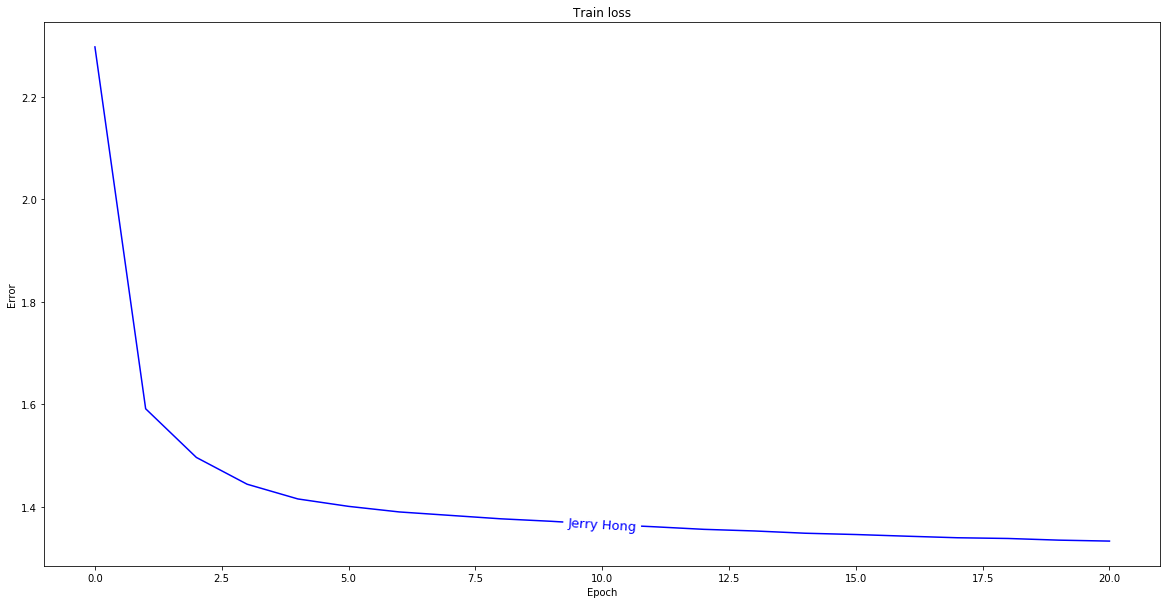

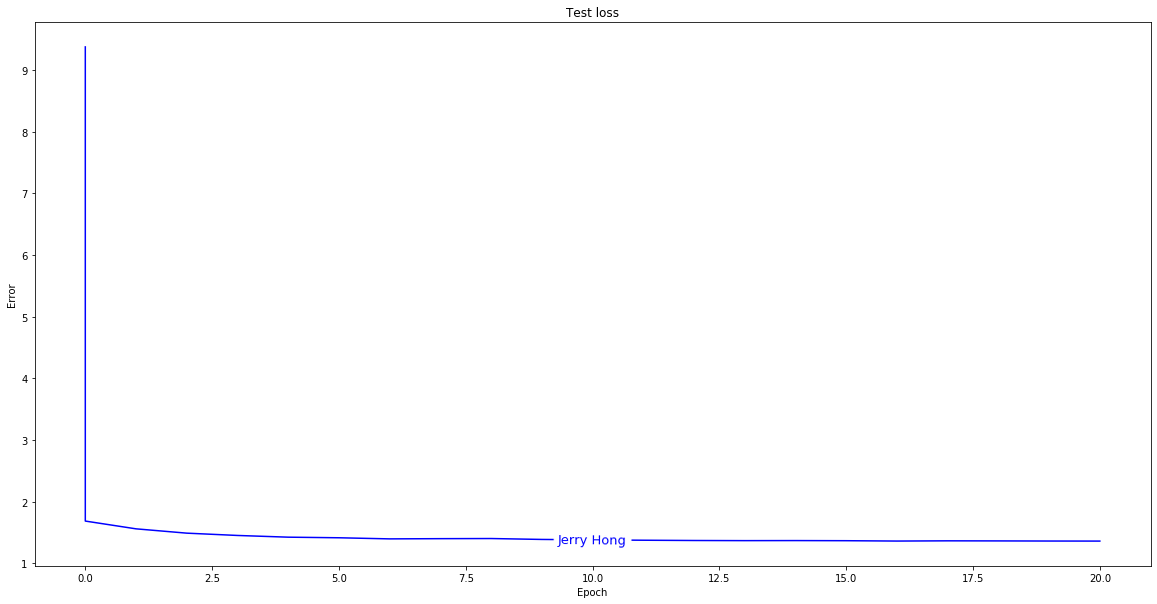

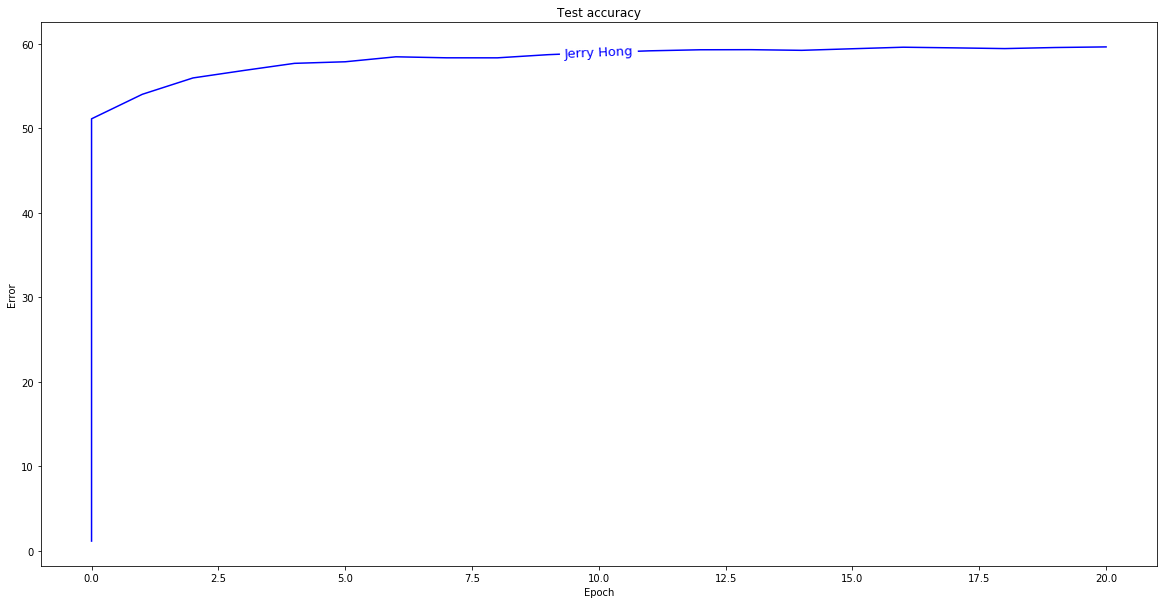

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    # setup GPU and multiprocessing
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    kwargs = {'num_workers': num_workers,'pin_memory': True} if use_cuda else {}

    # get train and test data
    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)

    # initialize model
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # This will train from scratch
    start_epoch = 0 
    train_losses, test_losses, test_accuracies = [], [], []

    # To resume training from last saved model, uncomment the following 2 lines
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    # Get initial test loss and accuracy
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            
            # train for 1 epoch
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            train_losses.append((epoch, train_loss))
            # test after 1 epoch
            test_loss, test_accuracy = test(model, device, test_loader)
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # Log the losses and accuracy
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            # save best model
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/language_%03d.pt' % epoch)
            
            # Test with a sentence starting with the given seed words. See what is generated next.
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated sentence\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/language_%03d.pt' % epoch, 0)
        # plot the loss and accuracy values
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error', name)
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error', name)
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error', name)
        return model, vocab, device

final_model, vocab, device = main()

# Submission.
Download a copy of this python notebook using File -> download .ipynb. Upload the following files on Canvas INDIVIDUALLY (**Do Not ZIP**):

- cse415A6.ipynb
- report.pdf
- cifar_050.pt
- language_020.pt

P.S. This codebase has been written following the codebase for the homework assignments of CSE499G1 / CSE599G1 (Introduction to Deep Learning) course during Fall 2019.